<a href="https://colab.research.google.com/github/sv650s/amazon-review-classification/blob/master/notebooks/deep_learning/4.2-biGRU-1_attention-balanced-prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Layer biDirectional GRU with Attention using TensorFlow 2



In [12]:
from google.colab import drive
import sys
drive.mount('/content/drive')
# add this to sys patch so we can import utility functions
DRIVE_DIR = 'drive/My Drive/Springboard/capstone'
sys.path.append(DRIVE_DIR)


%tensorflow_version 2.x


import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/device:GPU:0'

In [13]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, GRU, \
                                    Dropout, Bidirectional, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight



import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import importlib
import json
import re

# custom utilities
import util.dict_util as du
import util.plot_util as pu
import util.keras_util as ku
import util.file_util as fu
import util.report_util as ru

logging.basicConfig(level=logging.ERROR)

%matplotlib inline
sns.set()



# check to see if we are using GPU - must be placed at the beginning of the program
tf.debugging.set_log_device_placement(True)
print("GPU Available: ", tf.test.is_gpu_available())
print(f'Tensorflow Version: {tf.version.VERSION}')
print(f'Keras Version: {tf.keras.__version__}')


DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
LABEL_COLUMN = "star_rating"
FEATURE_COLUMN = "review_body"




DEBUG = False
MODEL_NAME = "GRU"
ARCHITECTURE = "1_bidirection_attention"
DESCRIPTION = "1 Layer Bi-directional GRU (250 units) with attention, balanced class weights"
FEATURE_SET_NAME = "random_embedding"


if DEBUG:
  DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-test1k-preprocessed.csv"
  MODEL_NAME = f'test-{MODEL_NAME}'
else:
  DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-200k-preprocessed.csv"



RSTATE = 1
EMBED_SIZE = 300
EPOCHS  = 200
BATCH_SIZE = 128
GRU_DIM = 250 # total GRU units
# from our previous notebook, we saw that 90% of our reviews have 100 or less
MAX_SEQUENCE_LENGTH = 100
PATIENCE = 8


GPU Available:  True
Tensorflow Version: 2.0.0
Keras Version: 2.2.4-tf


In [0]:

df = pd.read_csv(DATA_FILE)





# Pre-process our data


In [15]:

X_train, X_test, y_train, y_test, tokenizer = \
                                  ku.preprocess_file(data_df=df, 
                                                      feature_column=FEATURE_COLUMN, 
                                                      label_column=LABEL_COLUMN, 
                                                      max_sequence_length = MAX_SEQUENCE_LENGTH)

One hot enocde label data...


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Vocabulary size=52524
Number of Documents=199134
Splitting data into training and test sets...
Training X shape (149350, 100) y shape (149350, 5)
Test X shape (49784, 100) y shape (49784, 5)


# Implement our Attention Layer

In [0]:
from tensorflow.keras import backend as K


# define our attention layer for later
class AttentionLayer(layers.Layer):

    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        """

        self.supports_masking = True
        self.init = keras.initializers.get('glorot_uniform')

        self.W_regularizer = keras.regularizers.get(W_regularizer)
        self.b_regularizer = keras.regularizers.get(b_regularizer)

        self.W_constraint = keras.constraints.get(W_constraint)
        self.b_constraint = keras.constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        
        print(f'build.input_shape {input_shape}')
        print(f'build.input_shape[-1] {input_shape[-1]}')

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        
        print(f'build.features_dim {self.features_dim}')

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        # TF backend doesn't support it
        # eij = K.dot(x, self.W)
        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                              K.reshape(self.W, (features_dim, 1))),
                        (-1, step_dim))
        
        print(f'call.eij {eij}')

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        
        print(f'call.weighted_input {weighted_input}')

        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim

    def get_config(self):
        config = {'step_dim': self.step_dim}
        base_config = super(AttentionLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [17]:
vocab_size = len(tokenizer.word_counts)


# use functional syntax to create our graph
inp = layers.Input(shape=(MAX_SEQUENCE_LENGTH, ))
x = Embedding(vocab_size + 2, EMBED_SIZE, trainable=True)(inp)
x = Bidirectional(GRU(units=GRU_DIM*2, return_sequences=True))(x)
x = AttentionLayer(MAX_SEQUENCE_LENGTH)(x)
x = Dense(GRU_DIM*2, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(GRU_DIM, activation='relu')(x)
outp = Dense(5, activation='softmax')(x)

model = keras.models.Model(inputs=inp, outputs=outp)

model.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(), 
              metrics=['categorical_accuracy'])

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
build.input_shape (None, 100, 1000)
build.input_shape[-1] 1000
build.features_dim 1000
call.eij Tensor("attention_layer_1/Reshape_2:0", shape=(None, 100), dtype=float32)
call.weighted_input Tensor("attention_layer_1/mul:0", shape=(None, 100, 1000), dtype=float32)


In [18]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 300)          15757500  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 1000)         2406000   
_________________________________________________________________
attention_layer_1 (Attention (None, 1000)              1100      
_________________________________________________________________
dense_3 (Dense)              (None, 500)               500500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 250)               1252

In [19]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.4,
                              patience=PATIENCE, 
                              min_lr=0.00001,
                             mode='auto')

early_stop = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)

weights = compute_class_weight('balanced', np.arange(1, 6), df[LABEL_COLUMN])
print(f'class weights: {weights}')



mw = ku.ModelWrapper(model, 
                     MODEL_NAME,
                     ARCHITECTURE,
                     FEATURE_SET_NAME,
                     LABEL_COLUMN,
                     DATA_FILE,
                     embed_size=EMBED_SIZE,
                     tokenizer=tokenizer,
                     description=DESCRIPTION)

history = mw.fit(X_train, 
                y_train,
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                 class_weight = weights,
                  verbose=1,
                  validation_split=0.2,
                  callbacks=[early_stop, reduce_lr])

class weights: [1.43633872 3.07851898 2.18840596 1.19528211 0.3723871 ]
Number of training examples: 149350
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/d

Number of test: 49784
Running model.evaluate...
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
49784/1 [===============================================================================================================================================================================================================================================================================================================================================================================

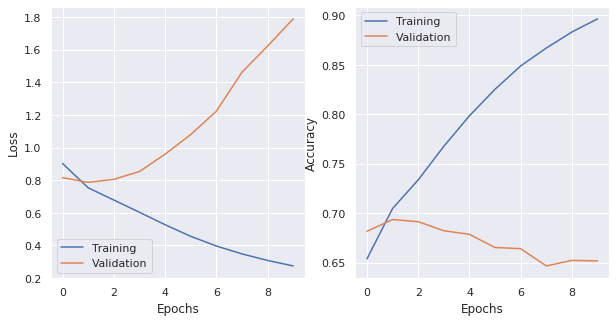


Confusion Matrix
[[ 5477   309   631   110   454]
 [ 1508   284   850   237   346]
 [  741   209  1457   994  1139]
 [  226    58   691  2222  5101]
 [  303    32   325  1159 24921]]

Classification Report
              precision    recall  f1-score   support

           1       0.66      0.78      0.72      6981
           2       0.32      0.09      0.14      3225
           3       0.37      0.32      0.34      4540
           4       0.47      0.27      0.34      8298
           5       0.78      0.93      0.85     26740

    accuracy                           0.69     49784
   macro avg       0.52      0.48      0.48     49784
weighted avg       0.64      0.69      0.65     49784



drive/My Drive/Springboard/capstone/util/plot_util.py:252: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:252: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:256: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:256: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  w

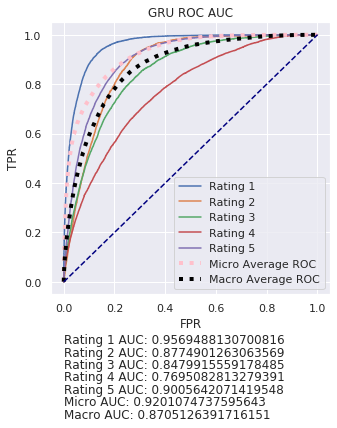

In [20]:
scores = mw.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (mw.scores[1]*100))



pu.plot_network_history(mw.network_history, "categorical_accuracy", "val_categorical_accuracy")
plt.show()

print("\nConfusion Matrix")
print(mw.confusion_matrix)

print("\nClassification Report")
print(mw.classification_report)

fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(mw.model_name, mw.roc_auc, mw.fpr, mw.tpr)

In [21]:
print(f'Score: {ru.calculate_metric(mw.crd)}')

Score: 0.24081072793342326


# Save off files so we can load later

In [22]:
mw.save(DRIVE_DIR, append_report=True)


description: GRU-1_bidirection_attention-random_embedding-sampling_none-199134-100-star_rating
Saving model file: drive/My Drive/Springboard/capstone/models/GRU-1_bidirection_attention-random_embedding-sampling_none-199134-100-star_rating-model.h5
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Saving json config file: drive/My Drive/Springboard/capstone/models/GRU-1_bidirection_attention-random_embedding-sampling_none-199134-100-star_rating-model.json
Saving weights file: drive/My Drive/Springboard/capstone/models/GRU-1_bidirection_attention-random_embedding-sampling_none-199134-100-star_rating-weights.h5
Saving to report file: drive/My Drive/Springboard/capstone/reports/2019-11-dl_prototype-report.csv
Loading to append to: drive/My Drive/Springboard/capstone/reports/2019-11-dl_prototype-report.csv
{'model_name': 'GRU', 'architecture': '1_bidirection_attention', 'description': '1 Layer Bi-directional GRU (250 units) with attention, balanced class wei

In [23]:
print(datetime.now())

2019-11-07 09:15:37.125783
